In [140]:
from scipy.stats import jf_skew_t
from scipy.stats.sampling import NumericalInversePolynomial
import scipy.stats as ss
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pysabr import Hagan2002NormalSABR
from fwdsabr.option_pricing import compute_option_prices
import warnings

# warnings.filterwarnings("ignore",)

In [8]:
class SabrDist(ss.rv_continuous):
    def __init__(self, f, shift, t, v_atm_n, beta, rho, volvol):
        super().__init__(name='SABR', a=-shift+1e-6, )
        self.sabr = Hagan2002NormalSABR(f=f, shift=shift, t=t, v_atm_n=v_atm_n, beta=beta, rho=rho, volvol=volvol)
    
    def _cdf(self, x):
        vols = self.sabr.normal_vol(x)
        return ss.norm.cdf(x, loc = self.sabr.f, scale = vols * np.sqrt(self.sabr.t))
    
    @classmethod
    def from_sabr(cls, sabr):
        return cls(f=sabr.f, shift=sabr.shift, t=sabr.t, v_atm_n=sabr.v_atm_n, beta=sabr.beta, rho=sabr.rho, volvol=sabr.volvol)

In [214]:
shift = 0.15
f = 0
strikes = np.linspace(-shift+0.02, shift-0.02, 1000)
sabr_p1 = Hagan2002NormalSABR(f = f, shift=shift, t = .5, v_atm_n=0.01, beta=0., rho=0, volvol=.0)
sabr_p1_p2 = Hagan2002NormalSABR(f = f, shift=shift, t = .5, v_atm_n=0.015, beta=0.5, rho=-0.5, volvol=1)
sabr_dist_p1 = SabrDist.from_sabr(sabr_p1)
sabr_dist_p1_p2 = SabrDist.from_sabr(sabr_p1_p2)

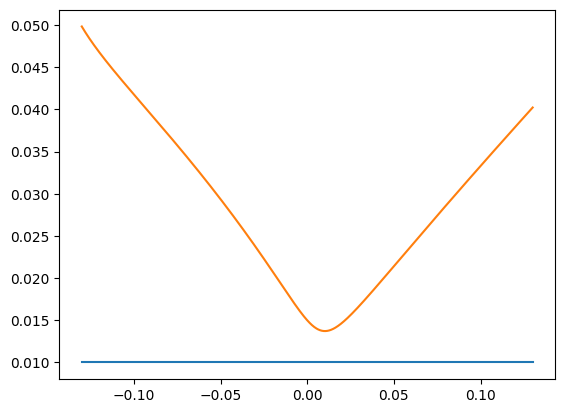

In [215]:
pdf_p1 = sabr_dist_p1.pdf(strikes) / sabr_dist_p1.pdf(strikes).sum()
pdf_p1_p2 = sabr_dist_p1_p2.pdf(strikes) / sabr_dist_p1_p2.pdf(strikes).sum()
plt.plot(strikes, sabr_p1.normal_vol(strikes), label='SABR 0.5')
plt.plot(strikes, sabr_p1_p2.normal_vol(strikes), label='SABR 1.0')

Text(0.5, 1.0, 'SABR Normal Volatility and PDF Comparison')

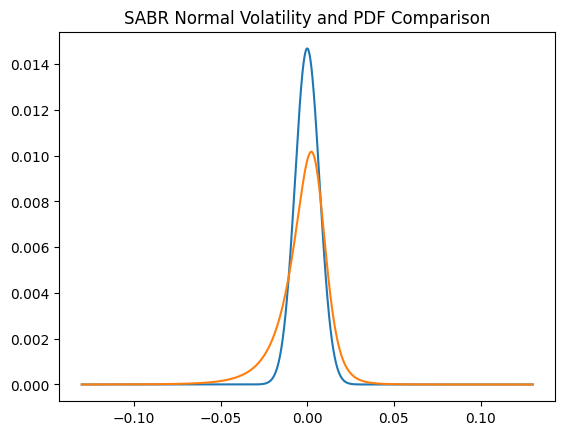

In [216]:
plt.plot(strikes, pdf_p1, label='SABR 0.5 PDF')
plt.plot(strikes, pdf_p1_p2, label='SABR 1.0 PDF')
plt.title('SABR Normal Volatility and PDF Comparison')

In [217]:
sampled_p1 = sabr_dist_p1.rvs(size=10_000) 

In [218]:
sampled_p1

array([-0.00835475, -0.00369058, -0.00399041, ...,  0.00244221,
        0.00424535,  0.00925216], shape=(10000,))

In [219]:
vols_p1_p2 = sabr_p1_p2.normal_vol(sampled_p1)
sampled_p1_p2 = np.random.randn(10_000, vols_p1_p2.shape[0]) * vols_p1_p2 * np.sqrt(.5) 
total = sampled_p1 + sampled_p1_p2
total

array([[ 0.01148771, -0.0025392 , -0.00069556, ...,  0.0035755 ,
         0.00926319,  0.00398479],
       [-0.00491462, -0.00491041, -0.01646945, ..., -0.00213034,
        -0.00605867,  0.0074258 ],
       [-0.01744459,  0.00582825, -0.0164952 , ...,  0.00860844,
         0.01629096,  0.00434865],
       ...,
       [-0.00011964,  0.00554028,  0.00046195, ..., -0.00097222,
        -0.0064316 , -0.00594827],
       [-0.00369803,  0.00212646, -0.00337402, ...,  0.00274768,
         0.00467287,  0.00336923],
       [-0.0048824 , -0.01003207, -0.00094833, ..., -0.00639912,
         0.01252586,  0.00690386]], shape=(10000, 10000))

(-0.13, 0.13)

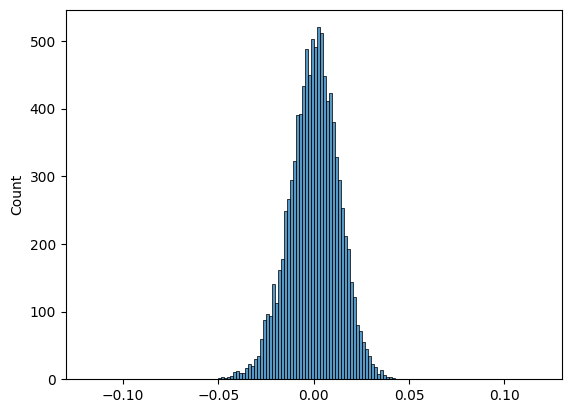

In [220]:
sns.histplot(data = total.flatten()[:10_000])
plt.xlim(strikes[0], strikes[-1])

In [221]:
vols_p1_p2 = sabr_p1_p2.normal_vol(strikes)

In [222]:
pdf = ss.norm.pdf(strikes.reshape(-1, 1), loc = strikes.reshape(1, -1), scale = vols_p1_p2.reshape(1, -1) * np.sqrt(.5))
pdf_df = pd.DataFrame(pdf, columns=pd.Index(strikes, name='Rate At Start'), index=pd.Index(strikes, name='Rate At End'))
pdf_df = pdf_df / pdf_df.sum()
pdf_total = (pdf_df * pdf_p1).sum(axis=1)
# pdf = pdf / pdf.sum(axis=0, keepdims=False)
# plt.plot(pdf.sum(axis = 1))


In [227]:
pdf_total.sum()

np.float64(1.0)

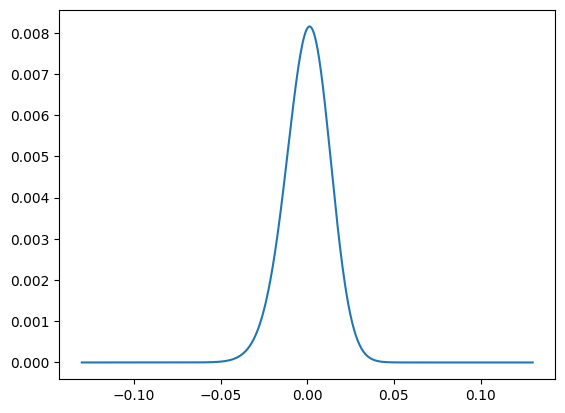

In [224]:
# pdf_total = (pdf * pdf_p1).sum(axis=1)
plt.plot(strikes, pdf_total)


In [226]:
pdf_total

Rate At End
-0.130000    1.284397e-14
-0.129740    1.395183e-14
-0.129479    1.515413e-14
-0.129219    1.645884e-14
-0.128959    1.787457e-14
                 ...     
 0.128959    7.005754e-16
 0.129219    6.958607e-16
 0.129479    6.911400e-16
 0.129740    6.864133e-16
 0.130000    6.816810e-16
Length: 1000, dtype: float64

In [225]:
pdf_total[strikes<-0.02].sum(), (total<-0.02).mean()


(np.float64(0.06629300045901156), np.float64(0.06609447))